# Project Cobra
### Logan Snyder, Iluda Ko, Brett Simmons, Joey Markun
This notebook will show various statistics of vehicle sales at the Ames Ford dealership, and compare those to some national car data. It will also consider tweets made about certain cars and how that compares to how well that car is selling. 

In [1]:
import tweepy
from keys import *
import requests
import pandas as pd
from textblob import TextBlob
import matplotlib.pylab as plt

client = tweepy.Client(bearer_token, api_key, api_secret_key, access_token, access_token_secret)
client = tweepy.Client( bearer_token=bearer_token, 
                        consumer_key=api_key, 
                        consumer_secret=api_secret_key, 
                        access_token=access_token, 
                        access_token_secret=access_token_secret, 
                        return_type = requests.Response,
                        wait_on_rate_limit=True)
# Define query
query = '(Ford F150) lang:en'
# get tweets
tweets = client.search_recent_tweets(query=query, 
                                    tweet_fields=['created_at'],
                                     max_results=50)
# Save data as dictionary
tweets_dict = tweets.json() 
# Extract "data" value from dictionary
tweets_data = tweets_dict['data'] 
# Transform to pandas Dataframe
twitter_df = pd.json_normalize(tweets_data) 

# make polarity and subjectiveness rows, using textblob to calculate the values for each
twitter_df['polarity'] = twitter_df['text'].apply(lambda x: float(TextBlob(x).sentiment.polarity)) #-1 to 1(positive)
twitter_df['subjectiveness'] = twitter_df['text'].apply(lambda x: float(TextBlob(x).sentiment.subjectivity))


# Add another row to the dataframe called sentiment. If the polarity is above 0.2, enter 'pos'. 
# If the sentiment is <-0.2 enter 'neg'. For polarity -0.2 to 0.2, count this as 'nt' (for neutral).
twitter_df.loc[:, 'sentiment'] = 'nt' #set all rows to neutral first 
twitter_df.loc[twitter_df['polarity'] > 0.2, 'sentiment'] = 'pos' #set all rows above this threshold to pos
twitter_df.loc[twitter_df['polarity'] < -0.2, 'sentiment'] = 'neg' #set the column 'sentiment' to neg for all rows w/ polarity below this threshold 

# calculate Total and percentage positives, negatives, and neutrals. 
pos_count = len(twitter_df.loc[twitter_df['sentiment'] == 'pos']) # the amount of rows where the sentiment is positive 
neg_count = len(twitter_df.loc[twitter_df['sentiment'] == 'neg'])
nt_count = len(twitter_df.loc[twitter_df['sentiment'] == 'nt']) 

twitter_df.head(5)

,created_at,id,text,polarity,subjectiveness,sentiment
0,2022-05-01T20:06:03.000Z,1520857100213272577,Smart!\n@Ford Is Forbidding Customers From Doi...,0.215476,0.826190,pos
1,2022-05-01T20:05:33.000Z,1520856975474577409,RT @39Magilla: @engineers_feed (8) Here are so...,0.500000,1.000000,pos
2,2022-05-01T20:01:38.000Z,1520855987124641795,RT @NameAndShame19: @TrueFactsStated Why would...,0.312121,0.784848,pos
3,2022-05-01T20:00:39.000Z,1520855741975998464,@engineers_feed (8) Here are some Mind-blowing...,0.500000,1.000000,pos
4,2022-05-01T19:58:17.000Z,1520855143859867648,RT @tommolog: Breaking: @Ford F-150 Lightning ...,0.100000,0.400000,nt


In [9]:
national_df = pd.read_csv("https://raw.githubusercontent.com/iludako/final_project/main/2021%20TruckSUV%20Sales.csv") 
#national sales data dictionary to access data later
national_data_dict = {}
for i in national_df.index:
    model = national_df.loc[i]['Model']
    sales = national_df.loc[i]['Total']
    sales = int(sales.replace(",",""))
    national_data_dict[model] = sales
national_df.drop(national_df.columns[[14]], axis = 1, inplace = True)
national_df.head(3)

,Model,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Total
0,Chevrolet Colorado,"7,707","7,707","8,670","4,989","4,797","4,989","4,285","4,126","4,285","7,151","7,151","7,151","73,008"
1,Chevrolet Silverado,"40,509","40,509","45,573","55,623","53,484","55,623","41,535","39,997","41,535","38,459","38,459","38,459","529,765"
2,Ford F-Series,"55,276","64,478","84,043","66,302","46,260","45,672","52,314","57,321","63,164","68,259","60,418","62,496","726,003"


In [3]:
local_df = pd.read_csv("https://raw.githubusercontent.com/iludako/final_project/main/MIS307%20Final%20Project%20Database.csv") 
local_df.drop(local_df.iloc[:,10:18], axis = 1, inplace = True)
local_df.head(3)


,StockNo,Customer ID,VehicleType,Model,CarTrim,DateSold,IsHybrid,IsDiesel,IsElectric,MPG
0,16517,7,Car,Mustang,EcoBoost,1/6/21,N,N,N,26.5
1,16385,62,Car,Mustang,EcoBoost,2/18/21,N,N,N,26.5
2,15687,185,Car,Mustang,EcoBoost,5/15/21,N,N,N,26.5


In [4]:
# set dictionary for counting trim occurances for the F-150 in local data
trim_count = {}
for i in local_df.index:
    if local_df.loc[i]['Model'] == "F-150":
        trim = local_df.loc[i]['CarTrim']
        if trim in trim_count: 
            trim_count[trim] +=1
        else: 
            trim_count[trim] = 1
        
print(trim_count)

{'King Ranch': 10, 'Lariat': 18, 'Limited': 5, 'Platinum': 7, 'Raptor': 4, 'XL': 41, 'XLT': 25}


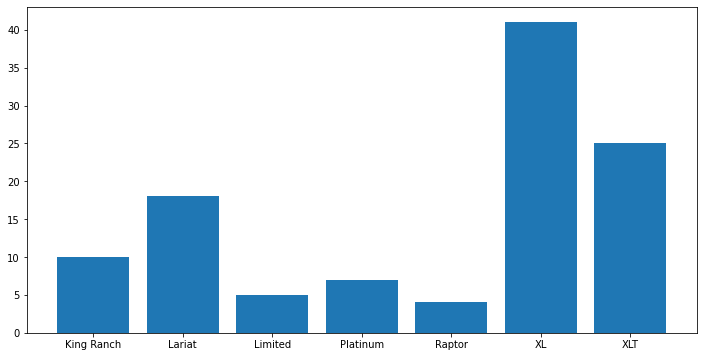

In [17]:
fig = plt.figure(figsize=(12,6))
plt.bar(range(len(trim_count)), trim_count.values(), align='center')
plt.xticks(range(len(trim_count)), list(trim_count.keys()))
plt.show()

In [10]:
# set dictionary for counting model occurances in local data
model_count = {}
for i in local_df.index:
    model = local_df.loc[i]['Model']
    if model in model_count: 
        model_count[model] +=1
    else: 
        model_count[model] = 1
        
print(model_count)

{'Mustang': 16, 'F-150': 110, 'F-250': 7, 'F-350': 13, 'F-450': 3, 'Expedition': 6, 'Explorer': 38, 'F-550': 1, 'Fusion': 6, 'Escape': 61, 'EcoSport': 10}


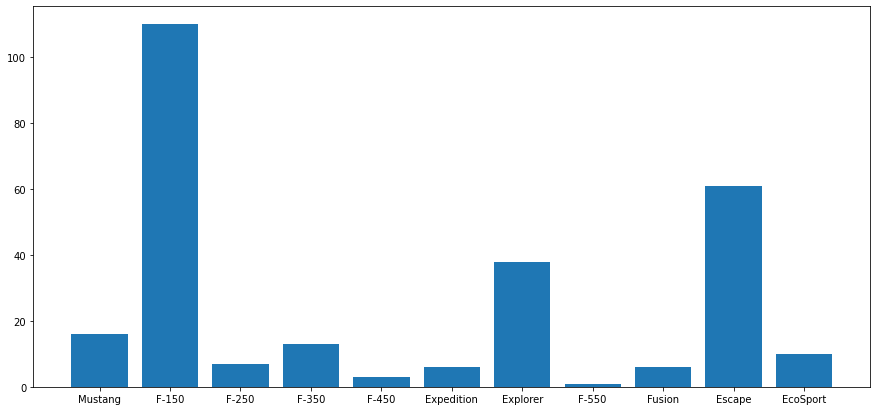

In [16]:
fig = plt.figure(figsize=(15,7))
plt.bar(range(len(model_count)), model_count.values(), align='center')
plt.xticks(range(len(model_count)), list(model_count.keys()))
plt.show()

In [ ]:
print("Ford F-Series truck sales nationwide compared to at the Ford dealership in Ames: \n\n")
print(f"The most popular selling Ford vehicle for the Ames dealership is the F-150, and it accounts for {model_count['F-150']/len(local_df.loc[:]) *100 :.2f}% of all sales at the dealership. ")
print(f"The Ford F-150 has various trim levels, and the most commonly sold trim in Ames is the 'XL' trim. Approximately {trim_count['XL']/model_count['F-150'] *100 :.2f}% of the F-150 trucks sold at the Ames deaslership were sold in this trim level.  ")


print(f"\n\nThe Ford F-Series accounted for {national_data_dict['Ford F-Series']/national_data_dict['All_Vehicle_Sale_Totals'] *100 :.2f}% of sales nation wide. ")

print("\n\n50 recent tweets about the Ford F-150 have the following average positivity levels: ")
print(f'% Positive Tweets: {pos_count/len(twitter_df) *100:.2f}% ')
print(f'% Negative Tweets: {neg_count/len(twitter_df) *100:.2f}% ')
print(f'% Neutral Tweets: {nt_count/len(twitter_df) *100:.2f}% ')